# Leaky buckets

A modeling exercise to simulate inflows and outflows of the soil water balance. This script shows the progress of the water level inside of a cylindrical bucket with a small hole at the bottom (a proxy for drainge).

*The problem was translated from notes by Tyson E. Ochsner following a Mathcad handout created by Tobi Ewing at Iowa State University.*

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve


## Model parameters

In [3]:
# Define parameters and constants
Q_in = 7 # cm^3/s
radius_bucket = 2.5 # cm
area_bucket = np.pi*radius_bucket**2 # cm^2
height_bucket = 30 # cm
radius_hole = 0.1 # cm
area_hole = np.pi*radius_hole**2 # cm^2
g = 981 # cm/s^2
density_water = 0.998 # [g/cm^3]
dyn_viscosity = 0.01 # g/(cm s)
dt = 10 # s
total_time = 250 # s
time_vector = np.arange(0,total_time,dt) # s

# Reynolds number (Re) and coefficient of discharge (CD) lookup table
Re_table = np.log10([1, 10, 100, 1000, 10000, 100000]); # dimensionless
CD_table = [0.04, 0.28, 0.73, 0.74, 0.64, 0.61];        # dimensionless

# Pre-allocate variables
L = len(time_vector)
height = np.ones((L,1))


## Explicit method (forward Euler method)

In [26]:
# Initial conditions (t=0)
height[0,:] = 0 # Bucket is empty at t=0

# Subsequent time steps (t=1 to end)
for i in range(1, L):
    # Calculate flux (q_in) into the bucket for current time step
    # Inflow (Q_in) is constant, so this step is easy
    q_in = Q_in / area_bucket # volume per unit area per unit time
    
    # Calculate flux out (q_out) of the bucket for current time step
    # Outflow (Q_out) is dependent on the current water into the bucket
    # so we need to account for the turbulent flow around the bicket hole
    # to find an accurate q_out.
    velocity = np.sqrt(2 * g * height[i-1,0])
    Re = 2 * radius_hole * density_water / dyn_viscosity * velocity
    Re = np.maximum(Re, 1)
    CD = np.interp(np.log10(Re), Re_table, CD_table)
    Q_out = CD * area_hole * velocity
    q_out = Q_out / area_bucket # volume per unit area per unit time
    
    # Calculate height of water into the bucket (mass balance)
    height[i,0] = np.minimum(height[i-1,0] + dt*(q_in - q_out), height_bucket)
    
height_explicit = height  # Save height variable with another name for plotting purposes.


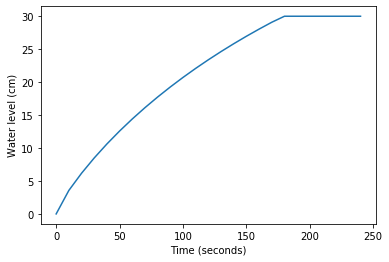

In [27]:
# Plot explicit solution
plt.plot(time_vector,height_explicit)
plt.xlabel("Time (seconds)")
plt.ylabel("Water level (cm)")
plt.show()


## Implicit method

In [28]:
# Initial conditions (t=0)
height = np.ones((L,1))
height[0,:] = 0 # Bucket is empty at t=0

# Subsequent time steps (t=1 to end)
for i in range(1, L):
    # Calculate flux (q_in) into the bucket for current time step
    # Inflow (Q_in) is constant, so this step is easy
    q_in = Q_in / area_bucket # volume per unit area per unit time
    h1 = height[i-1,0]
    
    # Create anonymous function as a function of h2 only (which is height at the end of the current time step)
    # Anonymous functions are called lambda functions in python. variables other than h2 are defined as in the
    # workspace at the time each iteration takes place.
    fnh2 = lambda h2: h2 - h1 - dt*(q_in - np.interp(np.log10(np.maximum(2 * radius_hole * density_water / dyn_viscosity * np.sqrt(2 * g * h2),1) ), Re_table, CD_table) * area_hole * np.sqrt(2 * g * h2) / area_bucket )
    
    # Initial guess (we assume no outflow, although not true, its close enough for the solver)
    x0 = h1 + q_in
    
    # Find value of h2 that makes the lambda function equal to zero (this will be the final height for this time step).
    height[i,0] = fsolve(fnh2,x0)
    
    # We still need to ensure that the water level is <= than the bucket height.
    height[i,0] = np.minimum(height[i,0], height_bucket)
    
height_implicit = height  # Save height variable with another name for plotting purposes.


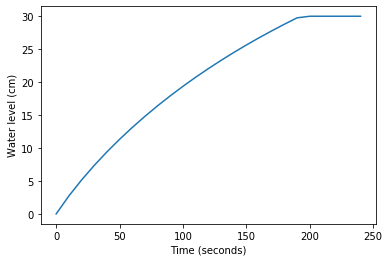

In [29]:
# Plot implicit solution
plt.plot(time_vector,height_implicit)
plt.xlabel("Time (seconds)")
plt.ylabel("Water level (cm)")
plt.show()


## Crank-Nicolson method

In [30]:
# Initial conditions (t=0)
height = np.ones((L,1))
height[0,:] = 0 # Bucket is empty at t=0

# Subsequent time steps (t=1 to end)
for i in range(1, L):
    # Calculate flux (q_in) into the bucket for current time step
    # Inflow (Q_in) is constant, so this step is easy
    q_in = Q_in / area_bucket # volume per unit area per unit time
    
    # Implicit (the backslash is used to partition the extremely long lines of code for better readability)
    h1 = height[i-1,0]
    fnh2 = lambda h2: h2 - \
                      h1 - \
                      dt*(q_in - \
                          np.interp(np.log10( max(2*radius_hole*density_water/dyn_viscosity*np.sqrt(2*g*h2),1) ), \
                                    Re_table, \
                                    CD_table) * \
                          area_hole * np.sqrt(2 * g * h2) / area_bucket )
    x0 = h1 + q_in
    height[i,0] = fsolve(fnh2,x0)
    
    # Crank-Nicolson
    height_mean = (height[i-1]+height[i,0]) / 2
    velocity = np.sqrt(2 * g * height_mean)
    Re = 2 * radius_hole * density_water / dyn_viscosity * velocity
    Re = np.maximum(Re, 1)
    CD = np.interp(np.log10(Re), Re_table, CD_table)
    Q_out = CD * area_hole * velocity
    q_out = Q_out / area_bucket # volume per unit area per unit time
    
    # Calculate height of water into the bucket (mass balance)
    height[i,0] = np.minimum(height[i-1,0] + dt*(q_in - q_out), height_bucket)    
        
height_cn = height  # Save height variable with another name for plotting purposes.


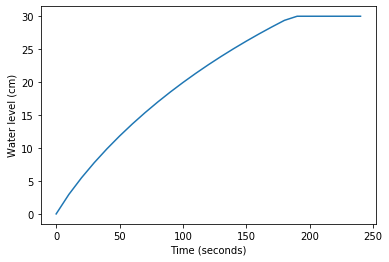

In [31]:
# Plot Crank-Nicolson solution
plt.plot(time_vector,height_cn)
plt.xlabel("Time (seconds)")
plt.ylabel("Water level (cm)")
plt.show()


## Compare solutions

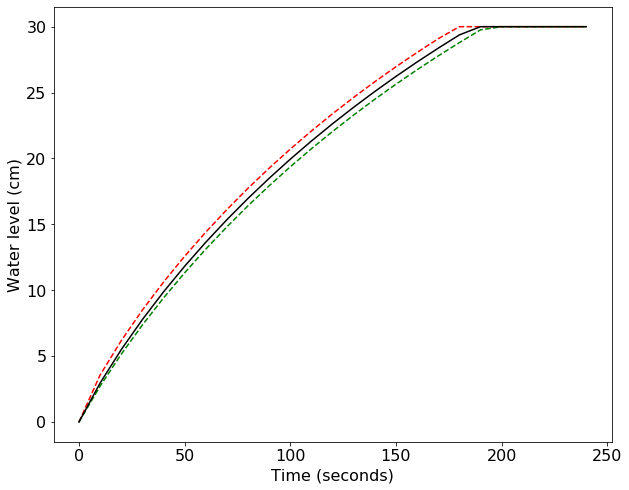

In [35]:
plt.figure(figsize=(10,8))
plt.plot(time_vector,height_explicit, '--r', label="Explicit")
plt.plot(time_vector,height_implicit, '--g', label="Implicit")
plt.plot(time_vector,height_cn, '-k', label="Crank-Nicolson")
plt.xlabel("Time (seconds)", size=16)
plt.ylabel("Water level (cm)", size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()